# 06. jhanvi831/Software-Engineer-Salary-Prediction

## Prediction & XAI with Gradient Boosting Regression - survey_results_public.csv

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')
import lime, shap
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
df = pd.read_csv('06_survey_results_public.csv')

In [2]:
# First 5 rows of the dataset
df.head()

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN


In [3]:
# All available columns, their counts and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83439 entries, 0 to 83438
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ResponseId                    83439 non-null  int64  
 1   MainBranch                    83439 non-null  object 
 2   Employment                    83323 non-null  object 
 3   Country                       83439 non-null  object 
 4   US_State                      14920 non-null  object 
 5   UK_Country                    4418 non-null   object 
 6   EdLevel                       83126 non-null  object 
 7   Age1stCode                    83243 non-null  object 
 8   LearnCode                     82963 non-null  object 
 9   YearsCode                     81641 non-null  object 
 10  YearsCodePro                  61216 non-null  object 
 11  DevType                       66484 non-null  object 
 12  OrgSize                       60726 non-null  object 
 13  C

## Preprocessing

In [4]:
# Take only the meaningful columns:
# country, education level, years of coding as professional, employment type & converted comp. yearly
df_sub = df[["Country", "EdLevel", "YearsCodePro", "Employment", "ConvertedCompYearly"]]
# ConvertedCompYearly will be renamed to Salary
df_sub = df_sub.rename({"ConvertedCompYearly": "Salary"}, axis=1)
print("DATASET SHAPE:", df_sub.shape)
df_sub.head(10)

DATASET SHAPE: (83439, 5)


,Country,EdLevel,YearsCodePro,Employment,Salary
0,Slovakia,"Secondary school (e.g. American high school, G...",NaN,"Independent contractor, freelancer, or self-em...",62268.0
1,Netherlands,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,"Student, full-time",NaN
2,Russian Federation,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,"Student, full-time",NaN
3,Austria,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,Employed full-time,NaN
4,United Kingdom of Great Britain and Northern I...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",10,"Independent contractor, freelancer, or self-em...",NaN
5,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,"Student, part-time",NaN
6,United States of America,"Secondary school (e.g. American high school, G...",NaN,I prefer not to say,NaN
7,Malaysia,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,"Student, full-time",NaN
8,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,Employed part-time,NaN
9,Sweden,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,Employed full-time,51552.0


In [5]:
# Rows with null salaries will be removed
df_sub = df_sub[df_sub['Salary'].notnull()]
print("DATASET SHAPE AFTER REMOVAL OF NULL SALARIES:", df_sub.shape)
df_sub.head(10)

DATASET SHAPE AFTER REMOVAL OF NULL SALARIES: (46844, 5)


,Country,EdLevel,YearsCodePro,Employment,Salary
0,Slovakia,"Secondary school (e.g. American high school, G...",NaN,"Independent contractor, freelancer, or self-em...",62268.0
9,Sweden,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,Employed full-time,51552.0
11,Spain,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,Employed full-time,46482.0
12,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,Employed full-time,77290.0
16,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,Employed full-time,17748.0
17,Canada,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,Employed full-time,46135.0
18,Singapore,"Other doctoral degree (Ph.D., Ed.D., etc.)",30,I prefer not to say,160932.0
23,France,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",2,Employed full-time,38915.0
24,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",18,Employed full-time,77831.0
26,Switzerland,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5,Employed full-time,81319.0


In [6]:
# Info about the current dataset
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46844 entries, 0 to 83438
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       46844 non-null  object 
 1   EdLevel       46823 non-null  object 
 2   YearsCodePro  46391 non-null  object 
 3   Employment    46831 non-null  object 
 4   Salary        46844 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.1+ MB


In [7]:
# Then, remove those rows containing null values. There should be no more...
df_sub = df_sub.dropna()
print("DATASET SHAPE AFTER REMOVAL OF ROWS WITH NULL:", df_sub.shape)
df_sub.isnull().sum()

DATASET SHAPE AFTER REMOVAL OF ROWS WITH NULL: (46359, 5)


Country         0
EdLevel         0
YearsCodePro    0
Employment      0
Salary          0
dtype: int64

In [8]:
# Also, select such rows where person was employed as full time
df_sub = df_sub[df_sub["Employment"] == "Employed full-time"]
df_sub = df_sub.drop("Employment", axis=1)
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40211 entries, 9 to 83438
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       40211 non-null  object 
 1   EdLevel       40211 non-null  object 
 2   YearsCodePro  40211 non-null  object 
 3   Salary        40211 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.5+ MB


In [9]:
# Let's filter the countries such that their counts lower than the cutoff value are moved to 'Other'
def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map

In [10]:
# After that, we have these counts of countries as below
country_map = shorten_categories(df_sub['Country'].value_counts(), 400)
# print(country_map)
print("CURRENT DATASET SHAPE:", df_sub.shape)
df_sub['Country'] = df_sub['Country'].map(country_map)
df_sub['Country'].value_counts()

CURRENT DATASET SHAPE: (40211, 4)


Other                                                   10725
United States of America                                 9175
India                                                    3385
Germany                                                  2753
United Kingdom of Great Britain and Northern Ireland     2604
Canada                                                   1553
France                                                   1396
Brazil                                                   1340
Spain                                                     890
Netherlands                                               835
Australia                                                 825
Poland                                                    775
Italy                                                     756
Russian Federation                                        741
Sweden                                                    735
Turkey                                                    458
Switzerl

In [11]:
# It's better to remove the outliers once and for all!
df_sub = df_sub[df_sub["Salary"] <= 200000]
df_sub = df_sub[df_sub["Salary"] >= 10000]
df_sub = df_sub[df_sub['Country'] != 'Other']  # Even other countries are dropped as well

In [12]:
print("CURRENT DATASET SHAPE:", df_sub.shape)

CURRENT DATASET SHAPE: (25580, 4)


In [13]:
# It's better to convert the such texts into numbers, so it can be processed appropriately.
def clean_experience(x):
    if x == 'More than 50 years':
        return 50
    if x == 'Less than 1 year':
        return 0.5
    return float(x)
df_sub['YearsCodePro'] = df_sub['YearsCodePro'].apply(clean_experience)

In [14]:
df_sub["YearsCodePro"].unique()

array([ 4. ,  5. ,  6. ,  2. , 18. , 21. , 16. , 10. ,  0.5,  3. , 15. ,
       12. ,  8. , 17. ,  1. , 14. , 26. , 34. , 11. , 25. , 24. , 22. ,
       13. ,  9. ,  7. , 39. , 20. , 27. , 23. , 30. , 19. , 35. , 33. ,
       43. , 40. , 29. , 38. , 31. , 42. , 28. , 46. , 32. , 36. , 37. ,
       47. , 45. , 44. , 41. , 50. , 49. , 48. ])

In [15]:
# Well, these need to be simplified, thus they can be handled easily
def clean_education(x):
    if 'Bachelor’s degree' in x:
        return 'Bachelor'
    if 'Master’s degree' in x:
        return 'Master'
    if 'Professional degree' in x or 'Other doctoral' in x:
        return 'PostGrad'
    return 'LessThanBachelor'
df_sub['EdLevel'] = df_sub['EdLevel'].apply(clean_education)

In [16]:
df_sub["EdLevel"].unique()

array(['Master', 'Bachelor', 'PostGrad', 'LessThanBachelor'], dtype=object)

In [17]:
# Simplify the country names especially for USA and United Kingdom
def simplify_country_names(country):
    if country == 'United States of America':
        return 'USA'
    elif country == 'United Kingdom of Great Britain and Northern Ireland':
        return 'United Kingdom'
    else:
        return country
df_sub['Country'] = df_sub['Country'].apply(simplify_country_names)

In [18]:
df_sub['Country'].unique()

array(['Sweden', 'Spain', 'Germany', 'Turkey', 'Canada', 'France',
       'Switzerland', 'United Kingdom', 'Russian Federation', 'Israel',
       'USA', 'Brazil', 'Italy', 'Netherlands', 'Poland', 'Australia',
       'India', 'Norway'], dtype=object)

## Prepare Train and Test Sets

In [19]:
# Unlike what was done in 1st regression series, we'll create dummy variables for both education levels and countries
dummy_edu = pd.get_dummies(df_sub['EdLevel'])
dummy_country = pd.get_dummies(df_sub['Country'])
df_sub2 = pd.concat([dummy_edu, dummy_country, df_sub['YearsCodePro'], df_sub['Salary']], axis=1)
print("CURRENT DATASET SHAPE:", df_sub2.shape)
df_sub2.head(10)

CURRENT DATASET SHAPE: (25580, 24)


,Bachelor,LessThanBachelor,Master,PostGrad,Australia,Brazil,Canada,France,Germany,India,...,Poland,Russian Federation,Spain,Sweden,Switzerland,Turkey,USA,United Kingdom,YearsCodePro,Salary
9,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,4.0,51552.0
11,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,5.0,46482.0
12,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,6.0,77290.0
16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2.0,17748.0
17,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,6.0,46135.0
23,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2.0,38915.0
24,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,18.0,77831.0
26,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,5.0,81319.0
27,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,21.0,68507.0
29,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,16.0,37752.0


### Type 1: Use All Columns

In [20]:
# Use 80% of the dataset as training, and 20% as testing
X = df_sub2.drop(columns='Salary', axis=1)
Y = df_sub2.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21)
print("TRAIN SIZE:", x_train.shape, y_train.shape, "  TEST SIZE:", x_test.shape, y_test.shape)

TRAIN SIZE: (20464, 23) (20464,)   TEST SIZE: (5116, 23) (5116,)


## Predict with Gradient Boosting Regression

In [21]:
gradBoost = GradientBoostingRegressor()
gradBoost.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [22]:
# Fit the training data into the Gradient boosting regression model, then make predictions on the test data
s_time = time.time()
gradBoost.fit(x_train, y_train)
y_pred = gradBoost.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 1.243 seconds.


In [23]:
print("INIT:", gradBoost.init_)  # The estimator that provides the initial predictions
print("ESTIMATORS (FIRST 5):\n{}".format(gradBoost.estimators_[:5]))  # The collection of fitted sub-estimators
# The number of estimators as selected by early stopping (if 'n_iter_no_change' is specified).
# Otherwise, it is set to 'n_estimators'
print("# OF ESTIMATORS:", gradBoost.n_estimators_)
print("# OF FEATURES:", gradBoost.n_features_in_)  # Number of features seen during fit
print("MAX FEATURES:", gradBoost.max_features_)  # The inferred value of max_features
print("FEATURE IMPORTANCES:", gradBoost.feature_importances_)  # The impurity-based feature importances
# The i'th score 'train_score[i]' is the loss of the model at iteration i on the in-bag sample.
# If subsample == 1, this is the loss on the training data.
print("TRAIN SCORE:\n{}".format(gradBoost.train_score_))

INIT: DummyRegressor()
ESTIMATORS (FIRST 5):
[[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x2A14C321740)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x2A14C321740)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x2A14C321740)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x2A14C321740)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x2A14C321740)]]
# OF ESTIMATORS: 100
# OF FEATURES: 23
MAX FEATURES: 23
FEATURE IMPORTANCES: [6.79518032e-05 9.60908949e-03 2.14198935e-03 5.13494081e-04
 5.32528417e-03 2.95802252e-02 1.14655018e-02 4.78914293e-03
 6.75028003e-04 5.65719390e-02 2.45696926e-02 1.4583610

In [24]:
# Compare the predicted values against the actual ones for the first 20 rows of the test set
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   75677.59611406301 |  69482.0
   73599.49264800068 | 108098.0
  125891.20904016352 | 189000.0
  110011.36122951646 | 115000.0
    78237.9055851782 |  47412.0
   130780.5726203365 | 200000.0
   84966.53630548934 |  84019.0
   97299.42553358026 |  80172.0
  38800.822917869584 |  37834.0
   44581.81189587191 |  43239.0
   84689.72399553162 | 148648.0
  100311.67990630594 | 150000.0
   135260.0844447517 | 183000.0
   55208.84844093881 |  64859.0
   62846.68219752912 |  70264.0
  136776.78807116867 | 150000.0
   93476.83263392153 |  66810.0
  43580.658629543475 |  45360.0
   95385.05950382906 |  84000.0
   42875.49248807724 |  38916.0


In [26]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(gradBoost, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())

MSE: 789405331.6193082
RMSE: 28096.35797784667
MAE: 20809.044701513187
R2 SCORE: 0.6128652207514054

# CROSS VALIDATION #
FITTING TIME: [1.00538588 0.96188736 0.96793842 0.95415831 0.97556305] -> 0.9729866027832031
SCORING TIME: [0.00819325 0.00851822 0.00932884 0.00830364 0.0084269 ] -> 0.008554172515869141
TRAIN SCORE: [0.63060101 0.6152982  0.61763474 0.61430245 0.61470344] -> 0.6185079684592372
TEST SCORE: [0.56427022 0.62259026 0.61397555 0.61135991 0.62846148] -> 0.6081314839740035


## Explain the Model with SHAP

In [27]:
shap.initjs()
shap_explainer = shap.Explainer(gradBoost, x_train)
shap_values = shap_explainer(x_test)
print(shap_values.shape)
print(shap_values)
print("\n EXPECTED VALUE:", shap_explainer.expected_value)

(5116, 23)
.values =
array([[ 3.56613953e+00,  7.31808667e+02, -4.90404902e+02, ...,
        -1.83393133e+04, -1.05596282e+03,  2.01150043e+03],
       [ 0.00000000e+00,  7.66905990e+02,  1.20765199e+03, ...,
        -1.85121771e+04, -1.09787624e+03,  7.73521065e+03],
       [ 3.56613953e+00,  7.70672560e+02, -7.74728198e+02, ...,
         3.73909083e+04, -8.98026731e+02,  8.13062590e+03],
       ...,
       [-1.69928375e+00,  6.19983706e+02, -4.98609893e+02, ...,
        -1.83357752e+04, -1.01028015e+03,  1.97461440e+04],
       [ 0.00000000e+00,  7.63728422e+02, -4.84403878e+02, ...,
        -1.85858185e+04, -1.08814033e+03,  1.07210934e+04],
       [ 0.00000000e+00, -4.74778402e+03, -4.79770424e+02, ...,
        -1.55966146e+04, -7.98872038e+02, -3.58733352e+03]])

.base_values =
array([77337.24704472, 77337.24704472, 77337.24704472, ...,
       77337.24704472, 77337.24704472, 77337.24704472])

.data =
array([[ 1.,  0.,  0., ...,  0.,  0.,  7.],
       [ 0.,  0.,  1., ...,  0.,  0.,

### SUMMARY OF EXPLAINABILITY WITH SHAP ###


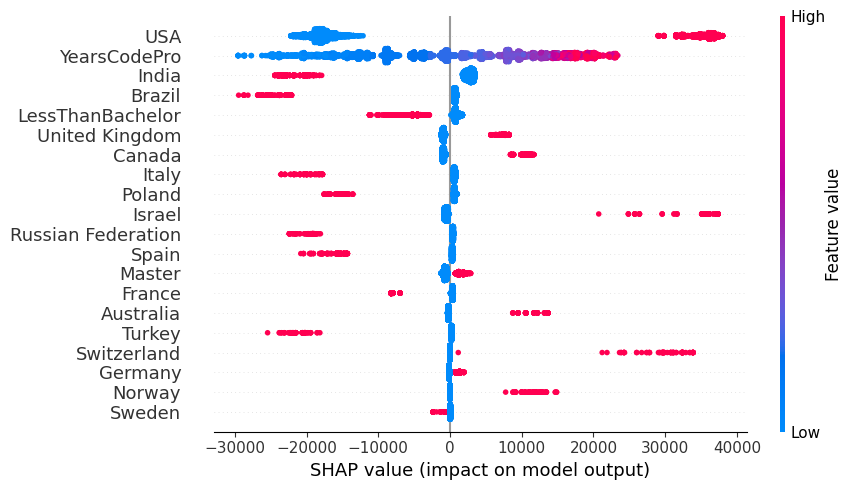

In [28]:
print("### SUMMARY OF EXPLAINABILITY WITH SHAP ###")
# shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, x_test, plot_type='dot', plot_size=[9,5])

In [29]:
print("### VISUALIZATION OF FIRST 1000 PREDICTIONS ###")
shap.plots.force(shap_values[:1000])

### VISUALIZATION OF FIRST 1000 PREDICTIONS ###


### MEAN ABSOLUTE VALUES OF SHAP VALUES ###


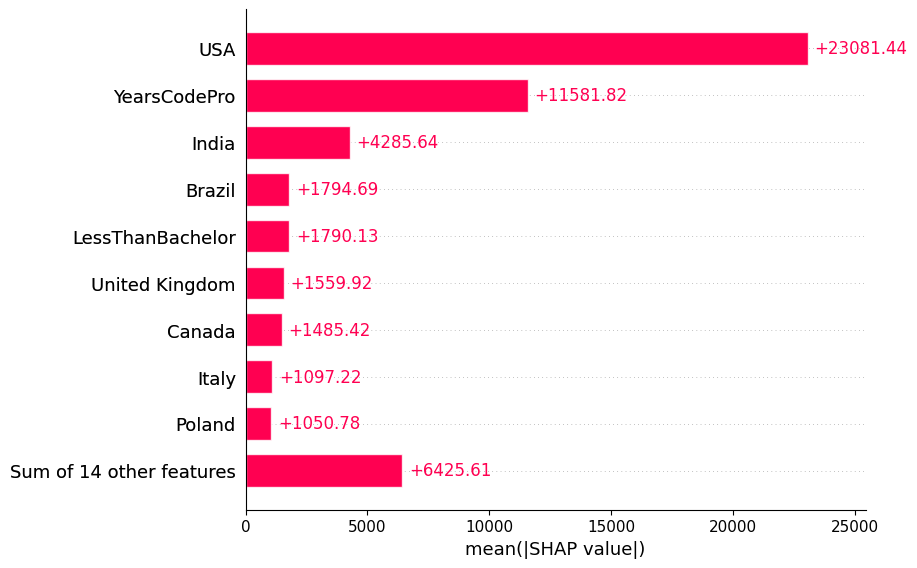

In [30]:
print("### MEAN ABSOLUTE VALUES OF SHAP VALUES ###")
shap.plots.bar(shap_values)

### DEPENDENCY BETWEEN THE FIRST COLUMN & THE BEST INTERACTION ###


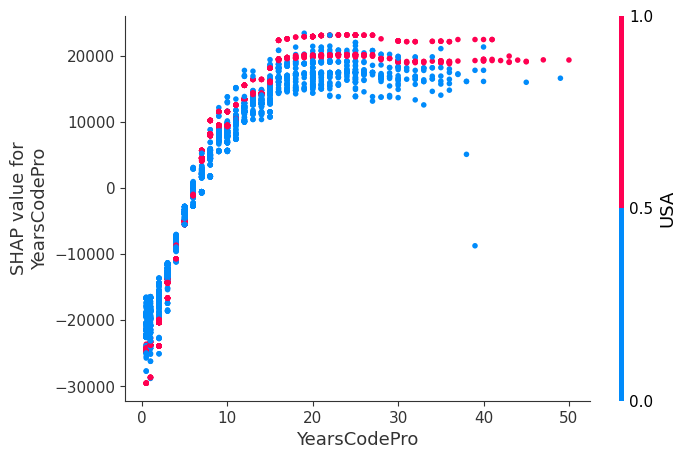

In [31]:
print("### DEPENDENCY BETWEEN THE FIRST COLUMN & THE BEST INTERACTION ###")
shap.dependence_plot("YearsCodePro", shap_values.values, x_test)

### EXPLAINING TEST ROW 3958 WITH SHAP ###


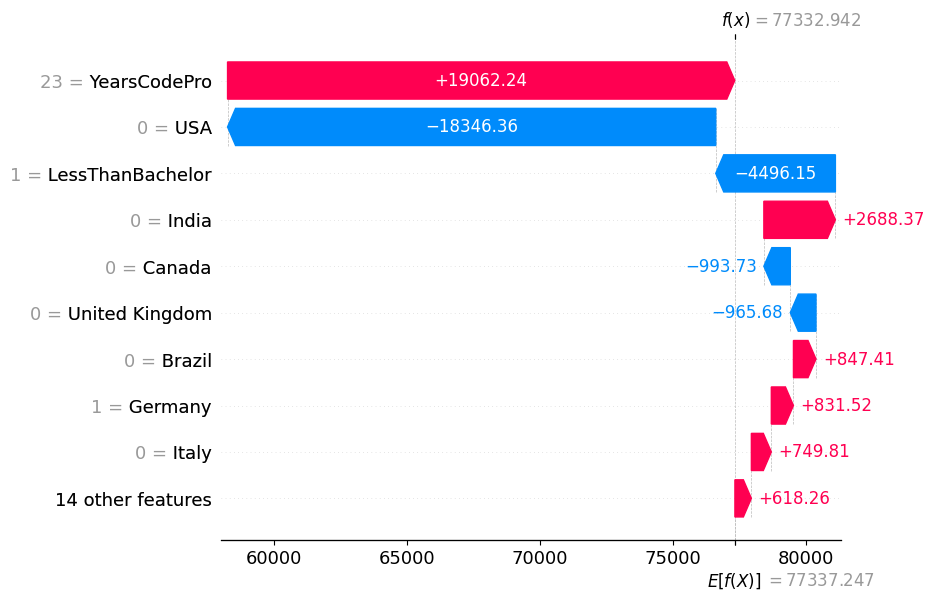

In [37]:
# i = 0
import random
i = random.randint(0, x_test.shape[0]-1)
print("### EXPLAINING TEST ROW {} WITH SHAP ###".format(i))
shap.plots.waterfall(shap_values[i])

In [38]:
print("### EXPLAINING TEST ROW {} WITH SHAP ###".format(i))
shap.plots.force(shap_values[i])

### EXPLAINING TEST ROW 3958 WITH SHAP ###


## Explain the Model with LIME

In [39]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=df_sub2.columns, 
                                                        class_names=['Salary'], verbose=True, mode='regression')

In [40]:
i = random.randint(0, x_test.shape[0]-1)
print("### EXPLAINING TEST ROW {} WITH LIME ###".format(i))
exp = lime_explainer.explain_instance(x_test.iloc[i], gradBoost.predict, num_features=10)
exp.show_in_notebook(show_table=True)
exp.as_list()

### EXPLAINING TEST ROW 3253 WITH LIME ###
Intercept 59889.39811522818
Prediction_local [42515.98637395]
Right: 28960.012290653696


[('USA <= 0.00', -52286.346075853464),
 ('Israel <= 0.00', -28344.52629344144),
 ('Switzerland <= 0.00', -28261.752583642145),
 ('Brazil <= 0.00', 22931.32686474999),
 ('Turkey <= 0.00', 22376.54229870738),
 ('India > 0.00', -22185.415473075354),
 ('Italy <= 0.00', 20156.266762010506),
 ('Russian Federation <= 0.00', 18439.293883539394),
 ('Poland <= 0.00', 15650.178073253343),
 ('Spain <= 0.00', 14151.020802477675)]